## Standard Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

from scipy.stats import zscore
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', 
                      category=FutureWarning)

## Get & Review Data

In [3]:
domain = 'https://raw.githubusercontent.com/'
loc = 'adamrossnelson/BirdsDataCreation/main/'
fname = 'BirdVarietyData_March2021.csv'

df = pd.read_csv(domain + loc + fname)

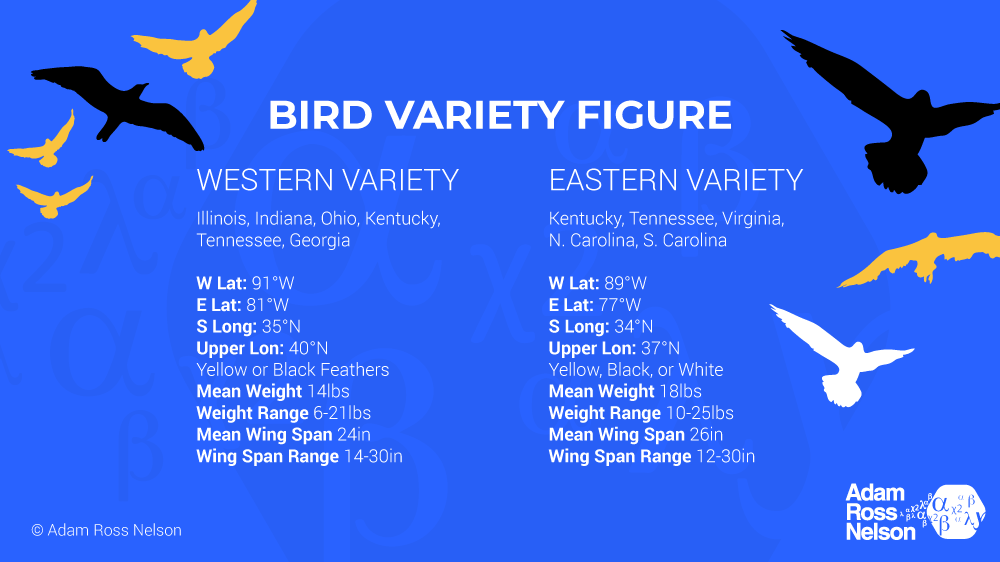

In [4]:
# Display Data Overview
from IPython.display import Image
domain = 'https://raw.githubusercontent.com/adamrossnelson/'
location = 'BirdsDataCreation/main/images/BirdVarietyFigure.png'
Image(domain + location, width=500)

In [5]:
df.head()

,lat,long,weight,wing,color,variety
0,83.921159,40.655318,12.059737,21.162858,Yellow,Western
1,89.532774,35.521465,19.620606,25.443436,Yellow,Western
2,85.376970,41.046102,8.922330,19.067410,Black,Western
3,85.446223,37.257189,14.052334,22.713154,Yellow,Western
4,84.285382,37.730382,19.421060,28.925393,Black,Western


## Encode Categorical Data

In [6]:
# One Hot Encoding with list comprehension.
df['isBlack'] = [1 if x == 'Black' else 0 for x in df['color']]
df['isWhite'] = [1 if x == 'White' else 0 for x in df['color']]
df['isYellow'] = [1 if x == 'Yellow' else 0 for x in df['color']]

Alternate code that will also accomplish One Hot Encoding.

```Python
df = pd.concat([df, pd.get_dummies(df[['color']], prefix='is')], axis=1)

```



In [7]:
# View the results of One Hot Encoding.
df.head()

,lat,long,weight,wing,color,variety,isBlack,isWhite,isYellow
0,83.921159,40.655318,12.059737,21.162858,Yellow,Western,0,0,1
1,89.532774,35.521465,19.620606,25.443436,Yellow,Western,0,0,1
2,85.376970,41.046102,8.922330,19.067410,Black,Western,1,0,0
3,85.446223,37.257189,14.052334,22.713154,Yellow,Western,0,0,1
4,84.285382,37.730382,19.421060,28.925393,Black,Western,1,0,0


## Standardize & Scale Data

In [8]:
# Mean and standard dev for later use in standardizing new observations.
scaler_data = df.drop(['variety','color'], 
                      axis=1).describe().transpose()[['mean','std']]

In [9]:
scaled_features = df.drop(['variety','color'], axis=1).apply(zscore)

Alternate code that will standardize based on zscore.

```Python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.drop(['variety','color'], axis=1))

scaled_features = scaler.transform(df.drop(['variety','color'], axis=1))
```

In [10]:
scaled_features

,lat,long,weight,wing,isBlack,isWhite,isYellow
0,-0.218368,1.613581,-0.906214,-1.618985,-0.843128,-0.449359,1.183622
1,1.393017,-0.968490,0.975750,0.280953,-0.843128,-0.449359,1.183622
2,0.199670,1.810126,-1.687141,-2.549051,1.186060,-0.449359,-0.844865
3,0.219557,-0.095508,-0.410240,-0.930885,-0.843128,-0.449359,1.183622
4,-0.113781,0.142484,0.926081,1.826422,1.186060,-0.449359,-0.844865
...,...,...,...,...,...,...,...
1995,-0.581093,0.581252,1.120771,-0.333779,1.186060,-0.449359,-0.844865
1996,-0.065227,-1.341930,-0.475400,-0.194381,-0.843128,-0.449359,1.183622
1997,0.542021,0.209131,0.094807,0.086022,-0.843128,2.225395,-0.844865
1998,-1.499142,-0.949464,-0.137050,0.748742,1.186060,-0.449359,-0.844865


## Train, Test, & Split The Data

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, 
                                                    df['variety'], 
                                                    test_size=0.2, 
                                                    random_state=1234)

## KNN Classification Imports

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
knn = KNeighborsClassifier(n_neighbors=1)

### Fit The Classification Model

In [15]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

### Make Predictions From Test Data

In [16]:
pred = knn.predict(X_test)

### Review & Evaluate The Results

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
# Crosstab shows True Positives & Negatives, plus False Positives & Negatives
pd.crosstab(pred, y_test)

variety,Eastern,Western
row_0,,
Eastern,172,33
Western,30,165


In [19]:
# Additional details from the sklearn's confusion matrix
print(confusion_matrix(pred, y_test))

[[172  33]
 [ 30 165]]


In [20]:
# Additional details from sklearns classification report

In [21]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     Eastern       0.84      0.85      0.85       202
     Western       0.85      0.83      0.84       198

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



## Search For Optimal K

In [22]:
error_rates = []
auc_scores = []

for i in range(1, 60):
    # Set k = to i
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    # Save the error rate with k = i
    error_rates.append(np.mean(pred_i != y_test))
    # Save the AUC score with k = -
    fpr, tpr, threshold = metrics.roc_curve(y_test=='Western', 
                                            pred_i=='Western',)
    auc_scores.append(metrics.auc(fpr, tpr))

Text(0, 0.5, 'Error Rate')

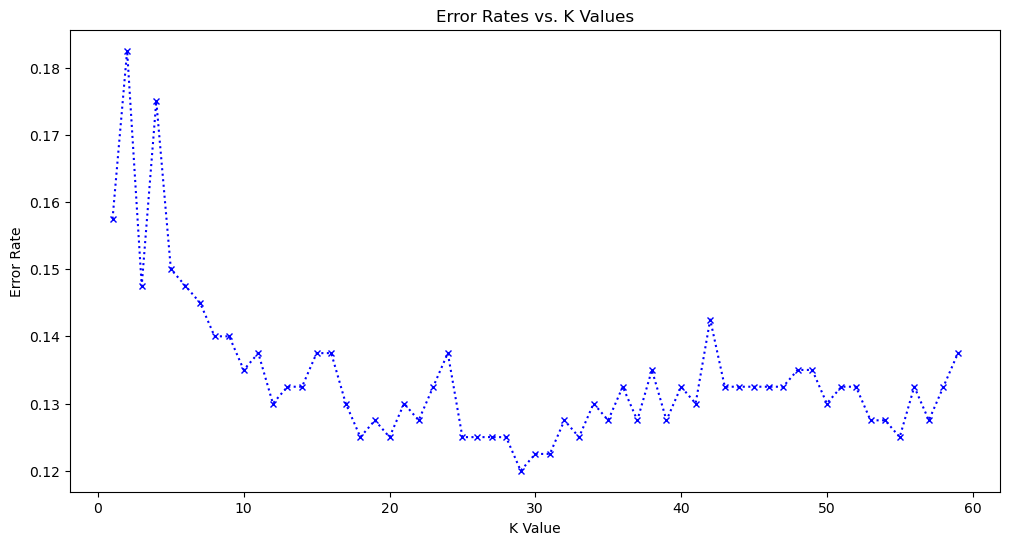

In [23]:
# Plot the error rates (which are inverse of AUC).
plt.figure(figsize=(12, 6))
plt.plot(range(1, 60), error_rates, color='blue',
         linestyle=':', marker='x', markersize=5)
plt.title('Error Rates vs. K Values')
plt.xlabel('K Value')
plt.ylabel('Error Rate')

Text(0, 0.5, 'AUC Scores Rate')

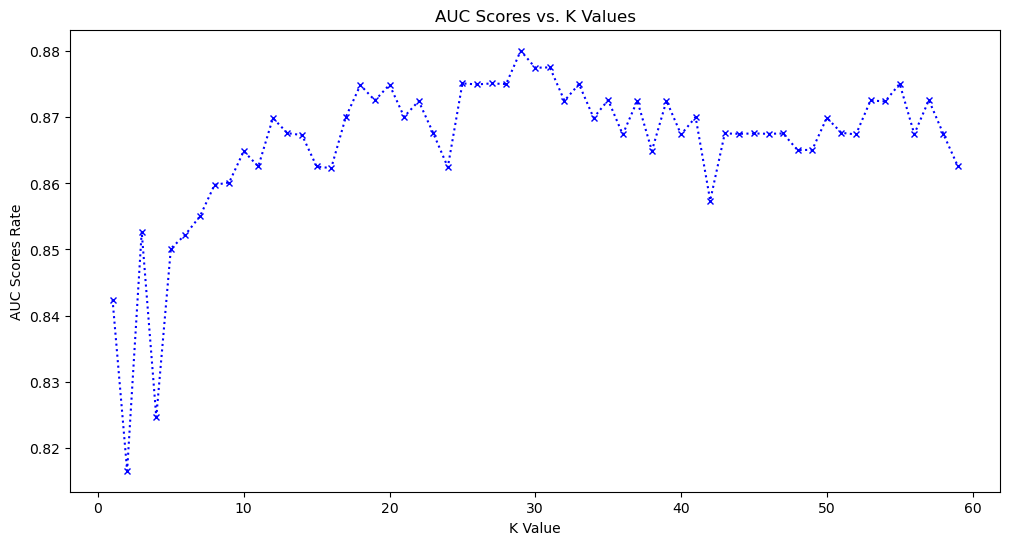

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 60), auc_scores, color='blue',
         linestyle=':', marker='x', markersize=5)
plt.title('AUC Scores vs. K Values')
plt.xlabel('K Value')
plt.ylabel('AUC Scores Rate')

## Draw ROC

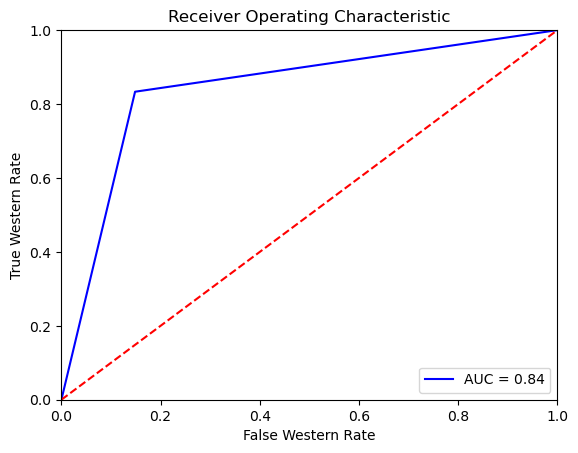

In [25]:
from sklearn import metrics

# Store FPR, TPR, and threshold as variables.
fpr, tpr, threshold = metrics.roc_curve(y_test=='Western', pred=='Western',)

roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Western Rate')
plt.xlabel('False Western Rate')
plt.show()

## Check Results At The Optimal K

In [26]:
knn = KNeighborsClassifier(n_neighbors=39)

knn.fit(X_train, y_train,)
pred = knn.predict(X_test)

print('WITH K=29')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

WITH K=29


[[176  26]
 [ 25 173]]


              precision    recall  f1-score   support

     Eastern       0.88      0.87      0.87       202
     Western       0.87      0.87      0.87       198

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



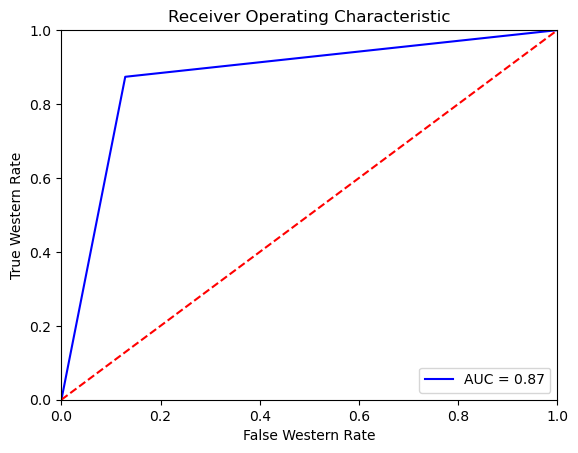

In [27]:

# Store FPR, TPR, and threshold as variables.
fpr, tpr, threshold = metrics.roc_curve(y_test=='Western', pred=='Western')

roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Western Rate')
plt.xlabel('False Western Rate')
plt.show()


In [28]:
threshold

array([2, 1, 0])

## Use The Model To Make New Predictions

In [29]:
def new_prediction(new_observation, scaler_data):
    # Scale the new observation
    new_obs_scaled = [(x - m) / sd 
                      for x, m, sd 
                      in zip(new_observation, 
                             scaler_data['mean'], 
                             scaler_data['std'])]
    return(knn.predict(np.array(new_obs_scaled).reshape(1, -1)))

In [30]:
new_prediction([80,35,15,19,0,1,0], scaler_data)

/Users/adamnelson/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['Eastern'], dtype=object)

In [31]:
new_prediction([80,35,15,19,1,0,0], scaler_data)

/Users/adamnelson/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['Western'], dtype=object)

In [32]:
new_prediction([80,35,15,19,0,0,1], scaler_data)

/Users/adamnelson/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['Western'], dtype=object)